# LMAPR1492 : Tâche 9

In [59]:
# Antonio Garção
# 33672100
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [60]:
mp_key = "zWerxXVKJ4OBcYhUP0oO4SXcDOfS6EVF"
mp_id = "mp-1960"

In [61]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
# J'initialise les variables utilies pour la suite
temperatures = np.arange(0,1000,5)
R = 8.314
nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*nat*R)

## 1) Modèles de Debye et d'Einstein

Historiquement, Einstein et Debye ont développé les premiers modèles de la chaleur spécifique

Je vais commencer par aborder la température de Debye liée au modèle de Debye. Ce modèle fait l'hypothèse que les fréquences ont la même dispersion linéaire : ωσ(q) = vq. Ensuite on peut développer le modèle en substituant la première zone de Brillouin par une sphère de rayon qd, de telle sorte que la sphère contienne Ncell vecteurs d'onde q autorisés, ce qui donne : (4/3)π (qd)^3=Ncell (2π)^3/V=(2π)^3/Ω. Ce modèle se base sur le seul paramètre empirique ѲD de telle sorte que : cv=9 Nat R(T/ѲD)^3ʃ (x4 ex)/(ex-1)² dx (les bornes de l’intégrales sont de 0 à ѲD) avec x=((ħ v q))/((Kb T)).

Pour ce qui est de la température d'Einstein, liée au modèle d'Einstein. L'hypothèse principale de ce modèle est que les fréquences ωσ(q) sont considérées égales à une fréquence de vibration ωE. On peut donc écrire : Cv=3 Nat R ((ħ ωE/(Kb T ))^2 (exp⁡(⁡〖((ħωE))/(Kb T) ))/(exp⁡(⁡((ħωE))/(Kb T)-1)².

#### Je vais effectuer la minimisation au sens des moindres carrés grâce (en grande partie) à un code (modifié) déjà utilisé dans un devoir précédent lié aux modèles de Debye et Einstein.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import integrate

# Définition du polynôme pour le modèle Debye
def polynome(x):
    return (x**4) * np.exp(x) / ((np.exp(x) - 1)**2)

# Définition du modèle Debye
def modeleDebye(d, T):
    cv_pred = 3*((T/d)**3) * integrate.quad(polynome, 0, d/T)[0]
    return cv_pred

# Modèle Einstein
def modele_einstein(e, T):
    cv_pred = ((e/T)**2) * np.exp(e/T) / ((np.exp(e/T) - 1) ** 2)
    return cv_pred

# Calcul de la température optimale de Debye
erreur_minin_d = 0
t_opt_d = 1
for i in range(1, 1000):
    erreur = 0
    for j in range(1, 200):
        cv_pred = modeleDebye(i, temperatures[j])
        erreur += (cv_pred - ph_cv[j])**2
    if i == 1:
        erreur_minim_d = erreur
    if erreur < erreur_minim_d:
        erreur_minim_d = erreur
        t_opt_d = i

# Calcul de la température optimale d'Einstein
erreur_minim_e = 0
t_opt_e = 1
for i in range(1, 1000):
    erreur = 0
    for j in range(1, 200):
        cv_pred = modele_einstein(i, temperatures[j])
        erreur += (cv_pred - ph_cv[j])**2
    if i == 1:
        erreur_minim_e = erreur
    if erreur < erreur_minim_e:
        erreur_minim_e = erreur
        t_opt_e = i

# Affichage des températures optimales
print("La température de Debye (optimale) est :", t_opt_d, "K")
print("La température d'Einstein (optimale) est :", t_opt_e, "K")

# Calcul des chaleurs spécifiques prédites par les modèles Debye et Einstein
cv_debye = [temperatures[0]]
cv_einstein = [temperatures[0]]
for i in range(1, 200):
    cv_debye.append(modeleDebye(t_opt_d, temperatures[i]))
    cv_einstein.append(modele_einstein(t_opt_e, temperatures[i]))

# Tracé du graphique avec Plotly
fig = go.Figure()

# Ajout des données expérimentales
scatter = go.Scatter(x=temperatures, y=ph_cv, mode='lines', name='Données fournies')
fig.add_trace(scatter)

# Ajout des données prédites par le modèle Debye
scatter_debye = go.Scatter(x=temperatures, y=cv_debye, mode='lines', name='Modèle de Debye')
fig.add_trace(scatter_debye)

# Ajout des données prédites par le modèle Einstein
scatter_einstein = go.Scatter(x=temperatures, y=cv_einstein, mode='lines', name='Modèle de Einstein')
fig.add_trace(scatter_einstein)

# Ligne rouge à y=1
fig.add_hline(y=1, line_width=2, line_color="red")

# Mise à jour du layout
fig.update_layout(
    xaxis={'title': "Température"},
    yaxis={'title': "Cv/3NatR"},
    xaxis_mirror=True,
    yaxis_mirror=True,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_ticks='inside',
    yaxis_ticks='inside',
    xaxis_ticklen=10,
    yaxis_ticklen=10,
)

# Affichage de la figure
fig.show()


La température de Debye (optimale) est : 825 K
La température d'Einstein (optimale) est : 610 K


## 2) Densités d'états de phonons

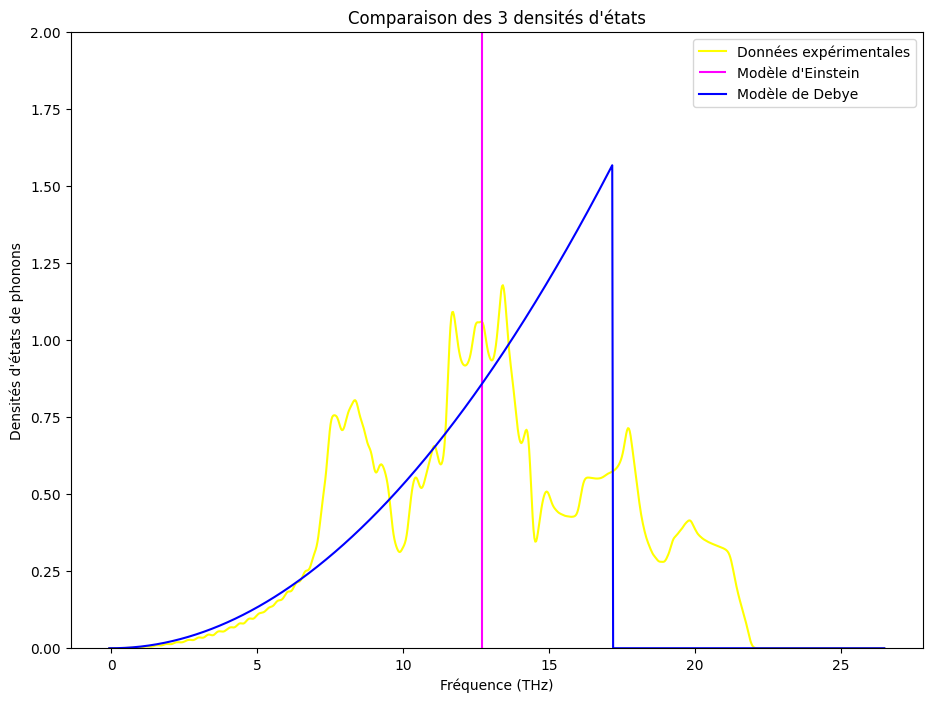

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes physiques
k_B = 1.380649e-23    # J/K
conv_THz = 1e-12
h_barre = 1.055e-34   # J.s

# Fréquences et densités de phonons
freq = ph_dos.frequencies 
dens = ph_dos.densities

# Fréquence caractéristique pour le modèle d'Einstein
omega_e = conv_THz * k_B * t_opt_e / h_barre
f_e = omega_e / (2 * np.pi)   # w = 2 pi f

# Fréquence caractéristique pour le modèle de Debye
omega_d = conv_THz * k_B * t_opt_d / h_barre

# Calcul de la densité de phonons pour le modèle de Debye
dens_d = np.zeros(len(freq))
for i, f in enumerate(freq):
    omega = 2 * np.pi * f
    if omega < omega_d:
        dens_d[i] = (9 * len(prim_struc) * (omega) ** 2 / (omega_d ** 3))

# Tracé du graphique
plt.figure(figsize=(11, 8))

# Données expérimentales
plt.plot(freq, dens, color="yellow", label="Données expérimentales")

# Modèle d'Einstein
plt.vlines(f_e, 0, 3 * len(prim_struc), color="magenta", label="Modèle d'Einstein")

# Modèle de Debye
plt.plot(freq, dens_d * (2 * np.pi), color='blue', label="Modèle de Debye")

plt.title("Comparaison des 3 densités d'états")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence (THz)")
plt.ylim(0, 2)
plt.legend()
plt.show()